# Classical Image Processing Approach to Image Registration
Using the [SimpleElastix Library](https://simpleelastix.github.io)

[Install here (takes around an hour to compile)](https://simpleelastix.readthedocs.io/GettingStarted.html#building-manually-on-linux)

In [1]:
import SimpleITK as sitk
import random
import os
import skimage
import nibabel as nib
from nibabel.analyze import AnalyzeHeader
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

In [2]:
def normalize(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image.astype('float32')

class MRIMaskDataset(Dataset):
    def __init__(self, root, transform, n_slices=120):
        self.transform = transform
        self.root = root
        self.n_slices = n_slices
        
    def __len__(self):
        return len(os.listdir(self.root))*self.n_slices
    
    def __getitem__(self, idx): 
        subdir = os.listdir(self.root)[idx//self.n_slices]
        slice_number = idx % self.n_slices
        
        # MRI
        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        image_shape = hdr.get_data_shape()
        width, height, depth, _ = image_shape

        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.img', 'rb')
        raw_image = np.fromfile(f, np.uint16)
        image = raw_image.reshape(image_shape).squeeze()
        
        image = image[::-1]
        image = image.swapaxes(0,1)
        image = image[slice_number]
        image = normalize(image)

        # Brain Mask
        f = open(f'{self.root}/{subdir}/{subdir}.native.brain.mask.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        mask_shape = hdr.get_data_shape()
        width, height, depth, _ = mask_shape
        
        f = open(f'{self.root}/{subdir}/{subdir}.native.brain.mask.img', 'rb')
        raw_mask = np.fromfile(f, np.uint8)
        mask = raw_mask.reshape(mask_shape).squeeze()
        
        mask = mask[::-1]
        mask = mask.swapaxes(0,1)
        mask = mask[slice_number]
        mask = mask.astype("float32")
        mask /= 255
            
        moving = self.transform({"image": image, "mask": mask})
            
        return moving["image"], moving["target"], moving["mask"], torch.Tensor(mask)

In [3]:
def mask_transforms(data):
    assert "image" in data and "mask" in data
    
    angle = random.randint(-20,20)
    trans_x = random.random()*0.4-0.2
    trans_y = random.random()*0.4-0.2
    scale = random.random()*0.3 + 0.6
    shear = random.random()*10-5
    
    image = TF.to_pil_image(data["image"])
    image = TF.affine(image, angle, (trans_x,trans_y), scale, shear,Image.BILINEAR)
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.1408],[0.1716])
    
    mask = TF.to_pil_image(data["mask"].astype("float32"))
    mask = TF.affine(mask, angle, (trans_x,trans_y), scale, shear,Image.BILINEAR)
    mask = TF.to_tensor(mask)
    
    target = TF.to_tensor(data["image"])
    target = TF.normalize(target, [0.1408],[0.1716])
    
    return {"image": image, "mask":mask, "target":target}

In [4]:
def accuracy(input, target):
    return 1-abs(target-input).sum()/target.sum()

In [5]:
data = MRIMaskDataset("LPBA40/native_space", mask_transforms)

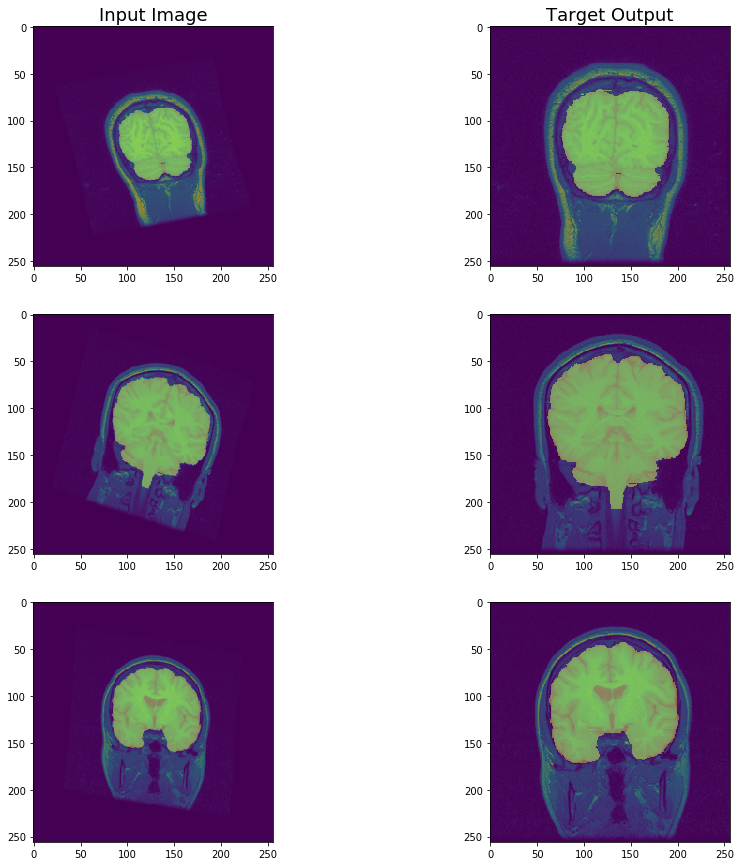

In [6]:
f, (ax0,ax1,ax2) = plt.subplots(3,2,figsize=(15,15))

im1 = data[20]
im2 = data[49]
im3 = data[789]

ax0[0].set_title("Input Image", fontsize=18)
ax0[0].imshow(im1[0].numpy().squeeze())
ax1[0].imshow(im2[0].numpy().squeeze())
ax2[0].imshow(im3[0].numpy().squeeze())

ax0[1].set_title("Target Output", fontsize=18)
ax0[1].imshow(im1[1].numpy().squeeze())
ax1[1].imshow(im2[1].numpy().squeeze())
ax2[1].imshow(im3[1].numpy().squeeze())

ax0[0].imshow(im1[2].numpy().squeeze(), alpha=0.4)
ax1[0].imshow(im2[2].numpy().squeeze(), alpha=0.4)
ax2[0].imshow(im3[2].numpy().squeeze(), alpha=0.4)

ax0[1].imshow(im1[3].numpy().squeeze(), alpha=0.4)
ax1[1].imshow(im2[3].numpy().squeeze(), alpha=0.4)
ax2[1].imshow(im3[3].numpy().squeeze(), alpha=0.4)

In [7]:
moving, fixed, moving_mask, fixed_mask = data[20]

In [8]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(fixed.numpy().squeeze()))
elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving.numpy().squeeze()));

In [9]:
%%time
elastixImageFilter.Execute();

CPU times: user 2.38 s, sys: 513 ms, total: 2.89 s
Wall time: 1.28 s


<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7fb759593780> >

In [10]:
resultLabel = sitk.Transformix(sitk.GetImageFromArray(moving_mask.numpy().squeeze()), 
                               elastixImageFilter.GetTransformParameterMap())
output_mask = sitk.GetArrayFromImage(resultLabel)
output = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())

MSE: 1.6449849605560303
Mask Accuracy: 0.5577721893787384


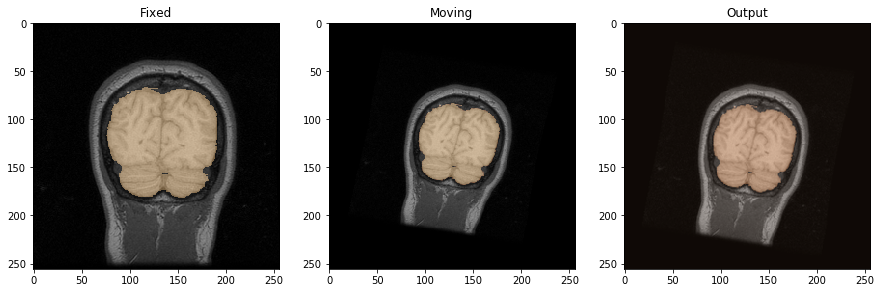

In [11]:
f, ax = plt.subplots(1,3,figsize=(15,20))
ax[0].set_title("Fixed")
ax[0].imshow(fixed.numpy().squeeze(),cmap="gray")
ax[0].imshow(fixed_mask.numpy().squeeze(), alpha=0.4, cmap="copper")

ax[1].set_title("Moving")
ax[1].imshow(moving.numpy().squeeze(),cmap="gray")
ax[1].imshow(moving_mask.numpy().squeeze(), alpha=0.4, cmap="copper")

ax[2].set_title("Output")
ax[2].imshow(output,cmap="gray")
ax[2].imshow(output_mask.squeeze(), alpha=0.4, cmap="copper")

print(f"MSE: {F.mse_loss(torch.Tensor(output), fixed)}")
print(f"Mask Accuracy: {accuracy(output_mask,fixed_mask.numpy().squeeze())}")

In [54]:
bs = 6
outputs = []
output_masks = []
elastixImageFilter = sitk.ElastixImageFilter()
parameterMapVector = sitk.VectorOfParameterMap()
parameterMapVector.append(sitk.GetDefaultParameterMap("affine"))
parameterMapVector.append(sitk.GetDefaultParameterMap("bspline"))
elastixImageFilter.SetParameterMap(parameterMapVector)

dl = DataLoader(data, batch_size=bs, shuffle=True, num_workers=4)    
moving, fixed, moving_mask, fixed_mask = next(iter(dl))

In [55]:
%%time

for i in range(bs):
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(fixed[i].numpy().squeeze()))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving[i].numpy().squeeze()))
    elastixImageFilter.Execute()
    resultLabel = sitk.Transformix(sitk.GetImageFromArray(moving_mask[i].numpy().squeeze()), 
                               elastixImageFilter.GetTransformParameterMap())
    output_mask = sitk.GetArrayFromImage(resultLabel)
    output = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
    outputs.append(output)
    output_masks.append(output_mask)
    print(f"MSE: {round(F.mse_loss(torch.Tensor(output), fixed[i].squeeze()).item(),4)}\tAccuracy: {round(accuracy(output_mask,fixed_mask[i].numpy().squeeze())*100,2)}%")

MSE: 0.0047	Accuracy: 98.48%
MSE: 0.0196	Accuracy: 97.36%
MSE: 0.0117	Accuracy: 97.86%
MSE: 0.0165	Accuracy: 97.69%
MSE: 0.0161	Accuracy: 98.22%
MSE: 0.0794	Accuracy: 92.51%
CPU times: user 1min 10s, sys: 15.2 s, total: 1min 25s
Wall time: 37 s


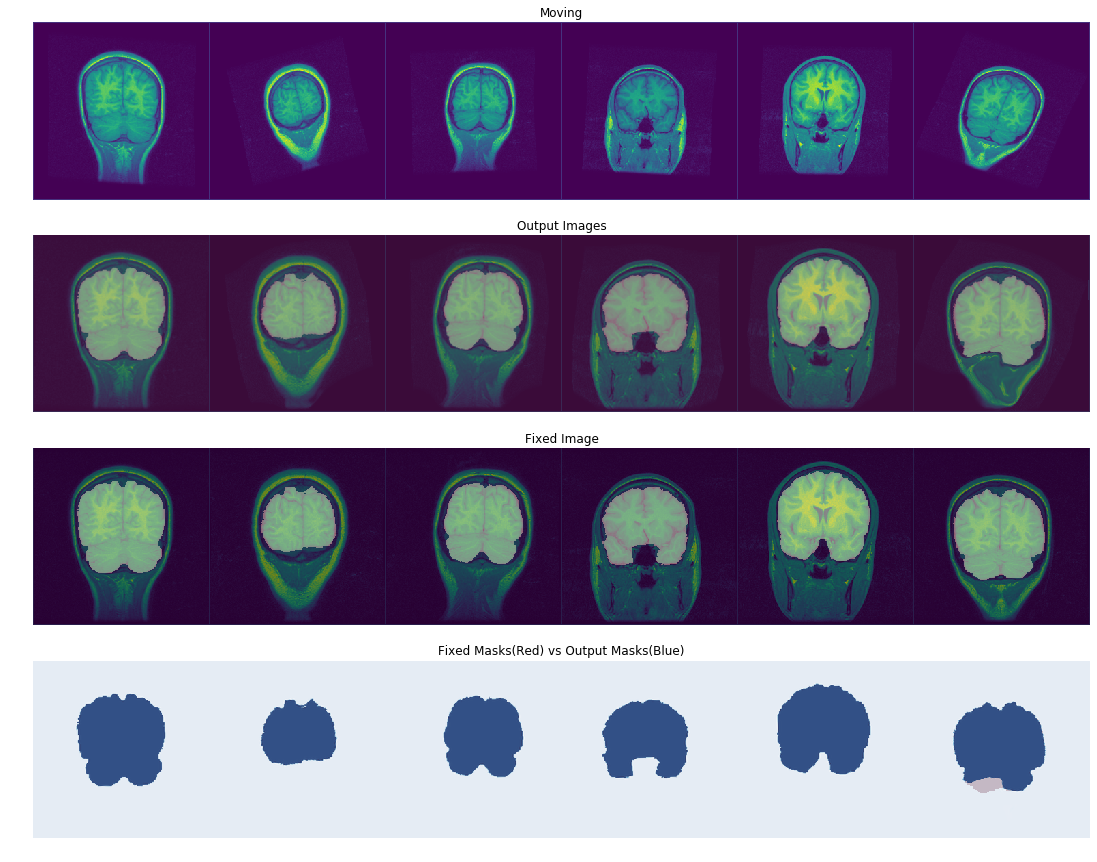

In [56]:
ims = np.stack(outputs)
f,ax = plt.subplots(4,1,figsize=(20,15))
ax[0].set_title("Moving")
ax[0].imshow(make_grid(moving).sum(0))

ax[1].set_title("Output Images")
ax[1].imshow(make_grid(torch.Tensor(ims)[:,None]).sum(0))
ax[1].imshow(make_grid(torch.Tensor(output_masks)[:,None]).sum(0), alpha=0.4, cmap="copper")

ax[2].set_title("Fixed Image")
ax[2].imshow(make_grid(fixed).sum(0))
ax[2].imshow(make_grid(fixed_mask[:,None]).sum(0), alpha=0.4, cmap="copper")

ax[3].set_title("Fixed Masks(Red) vs Output Masks(Blue)")
ax[3].imshow(make_grid(fixed_mask[:,None]).sum(0), alpha=0.7, cmap="Reds")
ax[3].imshow(make_grid(torch.Tensor(output_masks)[:,None]).sum(0), alpha=0.7, cmap="Blues")

for a in ax:
    a.set_axis_off()

Summary:

The SimpleElastix classical image registration approach performs reasonably well. It is clear that each image registered takes up to 2 seconds for the affine approach and leads to mediocre results. Using affine and bspline transforms, the time per image increases to about 6 seconds but the accuracy significantly improves.

It is unfortunate that all of the training from single images is thrown away for each iteration, causing the lack of generalisation and relatively long registering times. Learning from the data in order to generalise is what the learning based approach undertakes.